In [175]:
# Importamos las librerias necesarias
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device no fue encontrado.")

tensor([1.], device='mps:0')


In [176]:
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

In [177]:
# Asignamos el dataset a la variable "housing"
df = fetch_california_housing(as_frame=True)
df = df.frame

In [178]:
# Vemos las primeras 5 filas para verificar que haya importado correctamente
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [179]:
# Extraemos los valores de los inputs (X) y el output (y)
X = df[["MedInc","HouseAge","AveRooms","AveBedrms","Population","AveOccup",'Latitude','Longitude']].values
y = df['MedHouseVal'].values

In [180]:
# Hacemos split aleatorio de los datos para obtener datos de entrenamiento (80%) y de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
# Estandarizamos X para obtener mayor eficiencia computacional
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [182]:
# Movemos los tensores para hacer entrenamiento en GPU (device)
X_train_tensor = torch.tensor(X_train, device=device, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, device=device, dtype=torch.float32).view(-1, 1)  # reshape to (n_samples, 1)

X_test_tensor = torch.tensor(X_test, device=device, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, device=device, dtype=torch.float32).view(-1, 1)  # reshape to (n_samples, 1)

In [183]:
# Definimos el modelo de aprendizaje profundo
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.selu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = torch.relu(self.fc2(x))
        x = self.bn2(x)

        x = torch.relu(self.fc3(x))
        x = self.bn3(x)

        x = self.fc4(x)  # Output layer
        return x

In [185]:
# Instanciamos el modelo, la función de pérdida y el optimizador 
model = Net()
model.to(device)

criterion = nn.MSELoss() # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0065)

In [186]:
# Hacemos el bucle de entrenamiento del modelo
epochs = 8000
torch.autograd.set_detect_anomaly(True)
plot_x = []
plot_y = []
for epoch in range(epochs):

    optimizer.zero_grad() # Reseteamos los gradientes a cero para que no se acumulen

    outputs = model(X_train_tensor) # Aplicamos el forward pass
    loss = criterion(outputs, y_train_tensor) # Comparamos las predicciones (outputs) con respecto a los reales (y_train_tensor) para calcular el costo

    loss.backward() # Utilizamos la regla de la cadena para calcular el costo del gradiente con respecto a los parametros
    optimizer.step() # Ajustamos parametros para reducir el costo

    plot_x.append(epoch+1)
    plot_y.append(loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/8000], Loss: 0.2739
Epoch [200/8000], Loss: 0.2747
Epoch [300/8000], Loss: 0.2496
Epoch [400/8000], Loss: 0.2145
Epoch [500/8000], Loss: 0.2366
Epoch [600/8000], Loss: 0.2017
Epoch [700/8000], Loss: 0.2252
Epoch [800/8000], Loss: 0.2110
Epoch [900/8000], Loss: 0.2180
Epoch [1000/8000], Loss: 0.2151
Epoch [1100/8000], Loss: 0.2119
Epoch [1200/8000], Loss: 0.2096
Epoch [1300/8000], Loss: 0.2050
Epoch [1400/8000], Loss: 0.2109
Epoch [1500/8000], Loss: 0.2048
Epoch [1600/8000], Loss: 0.1976
Epoch [1700/8000], Loss: 0.2003
Epoch [1800/8000], Loss: 0.1983
Epoch [1900/8000], Loss: 0.1612
Epoch [2000/8000], Loss: 0.1972
Epoch [2100/8000], Loss: 0.1577
Epoch [2200/8000], Loss: 0.1922
Epoch [2300/8000], Loss: 0.1567
Epoch [2400/8000], Loss: 0.1904
Epoch [2500/8000], Loss: 0.1921
Epoch [2600/8000], Loss: 0.1897
Epoch [2700/8000], Loss: 0.1880
Epoch [2800/8000], Loss: 0.1873
Epoch [2900/8000], Loss: 0.1491
Epoch [3000/8000], Loss: 0.1841
Epoch [3100/8000], Loss: 0.1834
Epoch [3200/8000]

In [187]:
# Obtenemos MAE, MSE, y R2
with torch.no_grad():
    model.eval()
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    MAE = mean_absolute_error(y_test_tensor.cpu() , predictions.cpu())
    R2  = r2_score(y_test_tensor.cpu() , predictions.cpu())
    print('MAE = ', MAE)
    print(f'MSE = {mse.item()}')
    print('R2 = ', R2)

MAE =  0.3343488
MSE = 0.2533148229122162
R2 =  0.8066902699690964


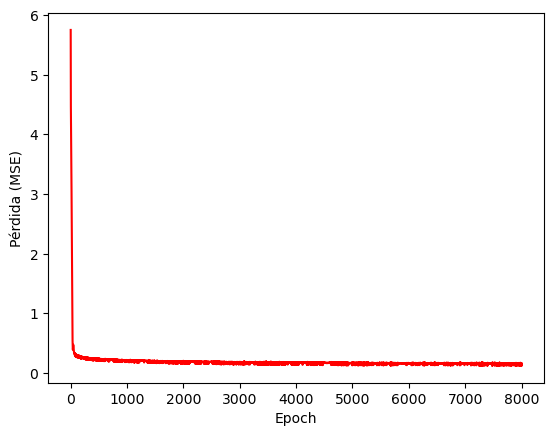

In [188]:
# Graficamos el comportamiento de la función de pérdida
plt.plot(plot_x, plot_y, color='red')
plt.xlabel('Epoch')
plt.ylabel('Pérdida (MSE)')
plt.show()

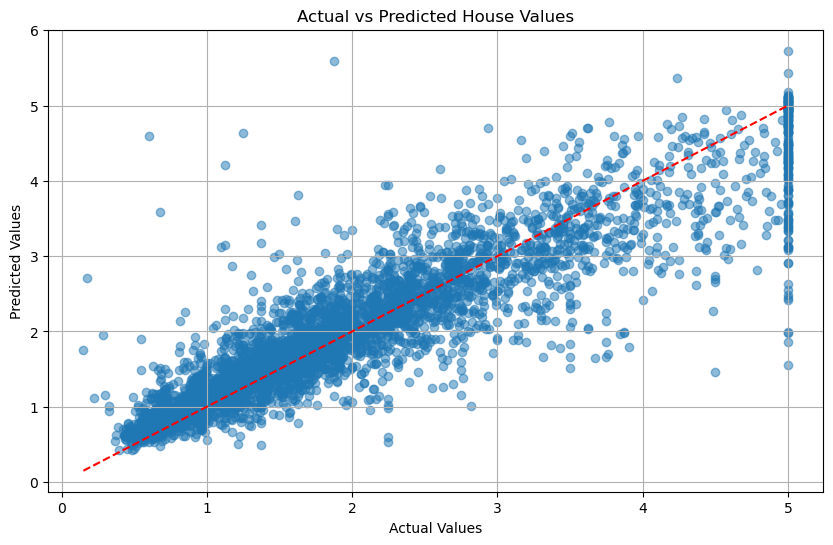

In [189]:
# Graficamos la diferencia entre los valores predichos y los reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.cpu(), predictions.cpu(), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted House Values')
plt.grid()
plt.show()